In [1]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers import LSTM, Flatten, Dropout
from keras.models import Sequential
from keras.layers import Input,Dense, LSTM,TimeDistributed, Flatten, Reshape
from keras.models import Model
import keras.backend as K
from keras.preprocessing import sequence
from keras.optimizers import Nadam
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# X_training = pickle.load(open("../data/X_train.pickle","rb"))
# Y_training = pickle.load(open("../data/Y_train.pickle","rb"))
# X_testing = pickle.load(open("../data/X_test.pickle","rb"))
# Y_testing = pickle.load(open("../data/Y_test.pickle","rb"))

# X_training_un = pickle.load(open("../data/X_train_un.pickle","rb"))
# Y_training_un = pickle.load(open("../data/Y_train_un.pickle","rb"))
# X_testing_un = pickle.load(open("../data/X_test_un.pickle","rb"))
# Y_testing_un = pickle.load(open("../data/Y_test_un.pickle","rb"))

# X_training = np.concatenate((X_training, X_training_un), axis=0)
# Y_training = np.concatenate((Y_training, Y_training_un), axis=0)
# X_testing = np.concatenate((X_testing, X_testing_un), axis=0)
# Y_testing = np.concatenate((Y_testing, Y_testing_un), axis=0)

# # Centering
# mux = np.mean(X_training, axis=0)
# stdx = np.std(X_training, axis=0)
# X_training = (X_training - mux)/stdx
# X_testing = (X_testing - mux)/stdx

In [3]:
data_dir = '../data2/f_D100_ush'

X_training = np.load(os.path.join(data_dir, "X_train.npy"))
Y_training = np.load(os.path.join(data_dir, "Y_train.npy"))

X_val = np.load(os.path.join(data_dir, "X_val.npy"))
Y_val = np.load(os.path.join(data_dir, "Y_val.npy"))

X_testing = np.load(os.path.join(data_dir, "X_test.npy"))
Y_testing = np.load(os.path.join(data_dir, "Y_test.npy"))


ds_rate = 1
X_training = np.array([val for key, val in enumerate(X_training) if key%ds_rate==0])
Y_training = np.array([val for key, val in enumerate(Y_training) if key%ds_rate==0])

X_val = np.array([val for key, val in enumerate(X_val) if key%ds_rate==0])
Y_val = np.array([val for key, val in enumerate(Y_val) if key%ds_rate==0])

X_testing = np.array([val for key, val in enumerate(X_testing) if key%ds_rate==0])
Y_testing = np.array([val for key, val in enumerate(Y_testing) if key%ds_rate==0])

# Centering and Normalizing data

mux = np.mean(X_training, axis=0)
stdx = np.std(X_training, axis=0)
X_training = (X_training - mux)/stdx
X_val = (X_val - mux)/stdx
X_testing = (X_testing - mux)/stdx

print("Data read and pre-processed")

Data read and pre-processed


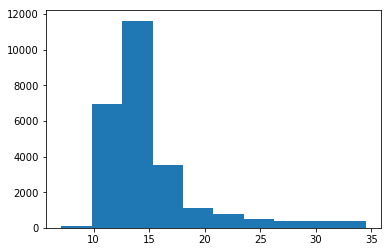

In [4]:
plt.hist(Y_training)
plt.show()

In [19]:
def get_model(time_steps = 30, data_dim = 50):
    in_neurons = 50
    out_neurons= 1
    hidden_neurons = 20
    
    # model = Sequential()
    # model.add(LSTM(hidden_neurons, input_shape=(time_steps, data_dim), return_sequences=True, activation="relu"))
    # # model.add(Flatten())
    # model.add(LSTM(25, return_sequences=False, activation="relu"))
    # model.add(Dense(out_neurons, input_shape = (time_steps, hidden_neurons), activation="linear"))
    # # model.add(Activation("linear"))
    # nadam = Nadam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    # model.compile(loss="mean_squared_error", optimizer=nadam)
    # L=len(X_training)

    layer1Dim = 256#100
    layer2Dim = 50
    inputs = Input(shape=(time_steps, data_dim))
#     batchNorm1 = BatchNormalization( name = "batch_norm_1")(inputs)
    lstm1 = LSTM(layer1Dim, return_sequences = True, name = 'lstm_1', activation="tanh")(inputs)
#     batchNorm2 = BatchNormalization( name = "batch_norm_2")(lstm1)
    dropout1 = Dropout(0.0)(lstm1)
    lstm2 = LSTM(layer2Dim, return_sequences = True, name = 'lstm_2', activation="relu")(dropout1)
    batchNorm3 = BatchNormalization( name = "batch_norm_3")(lstm2)
    flatten = Flatten()(lstm1)
    dense1 = Dense(512, activation="relu", name="Dense1")(flatten)
    dropout2 = Dropout(0.0)(dense1)
    output = Dense(1, activation='linear', name="Output")(dropout2)
    model = Model(inputs = inputs, outputs = output)
    
    op = dense1._keras_shape
    print(op[0], op[1])
    
    return model   

In [ ]:
get_model()

In [6]:
def get_model2(data_dim = 50):
    model = Sequential()
    model.add(Dense(input_shape=(data_dim,), output_dim=256))
    model.add(Activation("tanh"))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(output_dim=128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(output_dim=64))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(output_dim=1))   
    return model

In [7]:
def create_dataset(X, Y, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(X)-time_steps-1):
        a = X[i:(i+time_steps)]
        dataX.append(a)
        a = Y[(i+time_steps)]
        dataY.append(a)  #dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [8]:
time_steps = 30
trainX, trainY = create_dataset(X_training, Y_training, time_steps)
valX, valY = create_dataset(X_val, Y_val, time_steps)
testX, testY = create_dataset(X_testing, Y_testing, time_steps)

In [9]:
print(X_training.shape, Y_training.shape)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)
print(valX.shape, valY.shape)

(25694, 100) (25694,)
(25663, 30, 100) (25663,)
(1742, 30, 100) (1742,)
(10981, 30, 100) (10981,)


In [10]:
# # Training
# n_epochs = 20
# time_steps = 5
# data_dim = X_training.shape[1]
# rmses = np.zeros((time_steps, n_epochs))
# optimizer = optimizers.RMSprop(lr=1e-5)#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.004)

# for time_step in range(1,time_steps+1):
#     model = get_model(time_steps, data_dim)
#     model.compile(loss="mean_squared_error", optimizer=optimizer)
#     for i in range(n_epochs):
#         for j in range(L-time_steps):
#             X_train = np.reshape(X_training[j:j+time_steps,:], [1, time_steps, data_dim])
#             Y_train = np.reshape(Y_training[j+time_steps], [1, 1])
#             model.fit(X_train, Y_train, verbose=0, epochs=1)
#         rmse = get_rmse(model, X_testing, Y_testing, time_steps)
#         print("Time-Step {}/{} \t Epoch {}/{} \t RMSE = {}".format(time_step, time_steps, i+1, n_epochs, rmse))
#         rmses[time_step-1, i] = rmse
# #     print("Time Step {} done".format(time_step))

In [11]:
n_epochs = 50
data_dim = X_training.shape[1]
optimizer = optimizers.Adam()#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.004)
model = get_model(time_steps, data_dim)
model.compile(loss="mean_squared_error", optimizer=optimizer)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]
print(model.summary())
batch_size = 20
L=len(X_training)

# for i in range(n_epochs):
#     for j in range(0, L, batch_size):
#         X_train = np.reshape(X_training[j:j+batch_size,:], [1, batch_size, data_dim])
#         Y_train = np.reshape(Y_training[j+batch_size], [1, 1])
val_data = (valX, valY)
# model.fit(X_training, Y_training, batch_size=batch_size, epochs=20, validation_data=val_data)
# rmse = get_rmse(model, X_testing, Y_testing, time_steps)
# print("Time-Step {}/{} \t Epoch {}/{} \t RMSE = {}".format(time_step, time_steps, i+1, n_epochs, rmse))
# rmses[time_step-1, i] = rmse

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           365568    
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
_________________________________________________________________
Dense1 (Dense)               (None, 512)               3932672   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 4,298,753
Trainable params: 4,298,753
Non-trainable params: 0
_________________________________________________________________


In [12]:
#model.fit(X_training, Y_training, batch_size=batch_size, epochs=50, validation_data=val_data)

model.fit(trainX, trainY, batch_size=batch_size, epochs=200, validation_data=val_data, callbacks=callbacks_list)

Train on 25663 samples, validate on 10981 samples
Epoch 1/200
 2700/25663 [==>...........................] - ETA: 1:31 - loss: 24.1733

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error
preds = model.predict(testX)
# rmse = np.sqrt(np.mean((np.array(preds) - testY)**2))
rmse = np.sqrt(mean_squared_error(preds, testY))
print("RMSE", rmse)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(testY,'r',linewidth=1.0)
plt.show()

In [ ]:
# # Save model
model.save('model_lstm_S7_D100.h5')

# Load saved model
# model = load_model('model_mlp_time_data.h5')

In [ ]:
def get_rmse(model, X_testing, Y_testing, time_steps):
    preds=[]
    for j in range(len(X_testing)-time_steps):
        predicted = model.predict(np.reshape(X_testing[j:j+time_steps, :], [1, time_steps, X_testing.shape[1]]))
        preds.append(predicted[-1])

    Y_tst = Y_testing[time_steps:]
    rmse = np.sqrt(np.mean((np.array(preds) - Y_tst)**2))
    return rmse

In [ ]:
preds=[]
for j in range(len(X_testing)-time_steps):
    predicted = model.predict(np.reshape(X_testing[j:j+time_steps, :], [1, time_steps, X_testing.shape[1]]))
#     predicted = np.reshape(predicted, [10])
    preds.append(predicted[-1])
    
Y_tst = Y_testing[time_steps:]
rmse = np.sqrt(np.mean((np.array(preds) - Y_tst)**2))
print(rmse)

In [ ]:
preds = model.predict(X_testing)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_testing,'r',linewidth=1.0)
plt.show()

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
# model.save('mlp.h5')

In [ ]:
import keras
model = keras.models.load_model('mlp.h5')